# Preliminaries

In [61]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
# plt.rcParams['text.usetex'] = True  # nice but slow

import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1, SampleModel3
from dissipationtheory.dissipation9b import SampleModel1Jit, SampleModel3Jit
from dissipationtheory.dissipation18e import pointprobeCobject

In [3]:
from dissipationtheory.dissipation5 import ExptSweepConductivity
from dissipationtheory.dissipation5 import latex_float

In [4]:
THIS = 'dissipation-theory--Study-74--'
figs = {}
obj = {}

# Cantilever

Keep the cantilever parameters the same as in Study 41, so we can compare plots.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(2000, 'nm'))

Set the tip-sample separation and modulation frequency used below.

In [6]:
h = ureg.Quantity(75, 'nm')
wm = 1.0e5

# Spot-check point probe results for Type 3 samples

## High conductivity

In [7]:
sigma = ureg.Quantity(1E-2, 'S/m')
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

Here and below, set the AM modulation frequency to 250 Hz.

In [8]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(0., 250.)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.022    +2.200676e-02
   Delta f dc [Hz]      -0.684    -6.837454e-01
   Delta f ac [Hz]      -0.342    -3.418727e-01
   Delta f am [Hz]      -0.150    -1.495693e-01
--------------------------------------------------


## Low conductivity

In [9]:
sigma = ureg.Quantity(1E-9, 'S/m')
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

In [10]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(0., 250.)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.025    +2.465811e-02
   Delta f dc [Hz]      -0.620    -6.204534e-01
   Delta f ac [Hz]      -0.310    -3.102267e-01
   Delta f am [Hz]      -0.136    -1.357240e-01
--------------------------------------------------


## Compute the two $\Delta f_{\mathrm{DC}}$ limits

A function to compute the two bounds for $\Delta f_{\mathrm{DC}}$

In [11]:
def dfdclims(obj):
    
    es = obj.sample.epsilon_s
    eta = (es - 1)/(es + 1)
    
    fc = ureg.Quantity(obj.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(obj.sample.cantilever.k_c, 'N/m')
    
    R = ureg.Quantity(obj.sample.cantilever.R, 'm')
    V = ureg.Quantity(obj.sample.cantilever.V_ts, 'V')
    q0 = ureg.Quantity(4 * np.pi * epsilon0 * R * V, 'C')

    zc = ureg.Quantity(obj.info['r [nm]'] + obj.info['h [nm]'], 'nm')
    
    dfdc = -(fc * q0**2)/(4 * np.pi * epsilon0 * kc * 4 * zc**3)
    
    return np.array([dfdc.to('Hz').magnitude,
                     eta.real * dfdc.to('Hz').magnitude])

In [12]:
dfdclims(obj['pt 3'])

array([-0.68574061, -0.6204379 ])

We see that $\Delta f_{\mathrm{DC}}$ does indeed lie between these two bounds.

## $\Delta f_{\mathrm{DC}}$ versus charge density $\rho$

In [13]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1e0),
        num=200), 'S/m')

mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

In [14]:
gamma__array = np.zeros(len(sigma__array))
dfdc__array = np.zeros(len(sigma__array))

for index, (sigma, rho) in enumerate(zip(sigma__array, rho__array)):

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
        sigma = sigma,
        rho = rho,
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())

    obj['pt 3'] = pointprobeCobject(sample3_jit)
    obj['pt 3'].addsphere(h)
    obj['pt 3'].set_breakpoints(15)
    obj['pt 3'].properties(0., 250.)
    
    gamma__array[index] = obj['pt 3'].results['gamma [pN s/m]']
    dfdc__array[index] = obj['pt 3'].results['Delta f dc [Hz]']

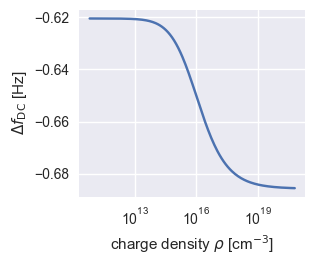

In [15]:
with plt.style.context('seaborn-v0_8'):

    figs['01'] = plt.figure(figsize=(3.25, 2.75))
    plt.semilogx(rho__array.to('1/cm^3').magnitude, dfdc__array)
    plt.xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    plt.ylabel('$\Delta f_{\mathrm{DC}}$ [Hz]')
    plt.tight_layout()
    plt.show()

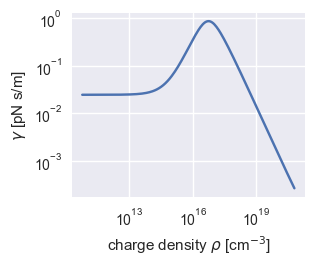

In [16]:
with plt.style.context('seaborn-v0_8'):

    figs['02'] = plt.figure(figsize=(3.25, 2.75))
    plt.loglog(rho__array.to('1/cm^3').magnitude, gamma__array)
    plt.xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    plt.ylabel('$\gamma$ [pN s/m]')
    plt.tight_layout()
    plt.show()

This plot looks reasonable.

## Frequency dependence

Compute the expected limiting values at low and high $\omega_{\mathrm{m}}$.

In [17]:
def dfaclims(obj):
    
    es = obj.sample.epsilon_s
    eta = (es - 1)/(es + 1)
    
    fc = ureg.Quantity(obj.sample.cantilever.f_c, 'Hz')
    kc = ureg.Quantity(obj.sample.cantilever.k_c, 'N/m')
    
    R = ureg.Quantity(obj.sample.cantilever.R, 'm')
    V = ureg.Quantity(obj.sample.cantilever.V_ts, 'V')
    q0 = ureg.Quantity(4 * np.pi * epsilon0 * R * V, 'C')

    zc = ureg.Quantity(obj.info['r [nm]'] + obj.info['h [nm]'], 'nm')
    
    dfdc = -(fc * q0**2)/(4 * np.pi * epsilon0 * kc * 4 * zc**3)
    dfac = -(fc * q0**2 * eta.real)/(8 * np.pi * epsilon0 * kc * 4 * zc**3)
    
    return np.array([dfdc.to('Hz').magnitude/2,
                     dfac.to('Hz').magnitude])

Now set up the sample again, printing out $\omega_0$.

In [18]:
sigma = ureg.Quantity(1E-5, 'S/m')
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
    sigma = sigma,
    rho = rho,
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

print(f"omega0 = {sample3_jit.omega0/sample3_jit.epsilon_s.real:0.2e} Hz")

omega0 = 5.65e+04 Hz


Low modulation frequency

In [19]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(0., 250.)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.236    +2.359125e-01
   Delta f dc [Hz]      -0.645    -6.453330e-01
   Delta f ac [Hz]      -0.323    -3.226665e-01
   Delta f am [Hz]      -0.141    -1.411666e-01
--------------------------------------------------


High modulation frequency

In [20]:
obj['pt 3'] = pointprobeCobject(sample3_jit)
obj['pt 3'].addsphere(h)
obj['pt 3'].set_breakpoints(15)
obj['pt 3'].properties(1e7, 250.)
obj['pt 3'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
       breakpoints      15.000    +1.500000e+01
           C0 [aF]       3.894    +3.894275e+00
             q0/qe      24.306    +2.430615e+01
    gamma [pN s/m]       0.236    +2.359125e-01
   Delta f dc [Hz]      -0.645    -6.453330e-01
   Delta f ac [Hz]      -0.310    -3.102314e-01
   Delta f am [Hz]      -0.136    -1.357262e-01
--------------------------------------------------


## Representative BLDS specta

In [21]:
omega_m__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=100), 'Hz')

In [22]:
def blds(omega_m__array, rho, mu):

    rho = ureg.Quantity(rho, '1/cm^3')
    mu = ureg.Quantity(mu, 'm^2/(V s)') 
    sigma = (qe * mu * rho).to('S/m')

    sample3 = SampleModel3(
        cantilever = cantilever,
        epsilon_s = ureg.Quantity(complex(20.0, -0.20), ''),
        sigma = sigma,
        rho = rho,
        z_r = ureg.Quantity(1, 'nm'))

    sample3_jit = SampleModel3Jit(**sample3.args())

    print(f"omega0 = {sample3_jit.omega0/sample3_jit.epsilon_s.real:0.2e} Hz")

    dfac__array = np.zeros(len(omega_m__array))

    obj['pt 3'] = pointprobeCobject(sample3_jit)
    obj['pt 3'].addsphere(h)
    obj['pt 3'].set_breakpoints(15)

    for index, omega_m in enumerate(omega_m__array):

        obj['pt 3'].properties(omega_m.to('Hz').magnitude, 250.)    
        dfac__array[index] = obj['pt 3'].results['Delta f ac [Hz]']
        
    return dfac__array

In [23]:
def plotme(omega_m__array, dfac__array):
    
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.25, 2.00))
        plt.semilogx(omega_m__array.to('Hz').magnitude, np.abs(dfac__array))
        plt.xlabel(r'modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
        plt.ylabel('$|\Delta f_{\mathrm{AC}}|$ [Hz]')
        plt.ylim([0.300, 0.365])
        
        return fig

omega0 = 9.05e+07 Hz


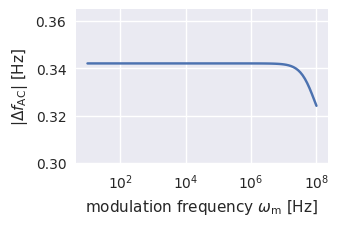

In [24]:
plotme(omega_m__array, blds(omega_m__array, 1e19, 1e-8))

omega0 = 9.05e+06 Hz


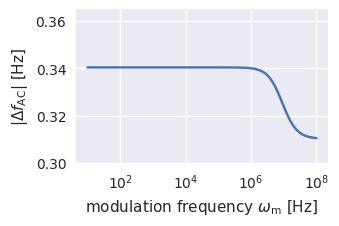

In [25]:
plotme(omega_m__array, blds(omega_m__array, 1e18, 1e-8))

omega0 = 9.05e+05 Hz


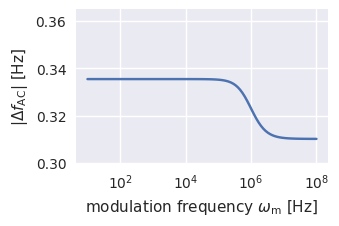

In [26]:
plotme(omega_m__array, blds(omega_m__array, 1e17,1e-8))

omega0 = 9.05e+04 Hz


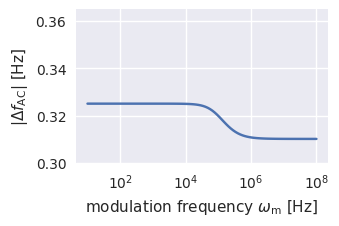

In [27]:
plotme(omega_m__array, blds(omega_m__array, 1e16, 1e-8))

omega0 = 9.05e+03 Hz


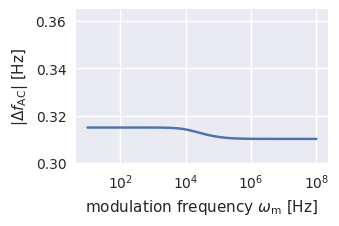

In [28]:
plotme(omega_m__array, blds(omega_m__array, 1e15, 1e-8))

# Vary conductivity (and charge density)

## Sweep parameters

In [270]:
N_omega = 100 # 10 or 100
N_sigma = 200 # 20 or 200

Set up an array of $\omega_{\mathrm{m}}$ values.

In [271]:
omega_m__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

Set up an array of conductivity $\sigma$ values.

In [272]:
sigma__array = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1e0),
        num=N_sigma), 'S/m')

Compute the charge density $\rho = \sigma \big/ q_e \mu$ corresponding to a mobility of $\mu = 10^{-8} \: \mathrm{m}^2 \mathrm{V}^{-1} \mathrm{s}^{-1}$.

In [273]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho__array = (sigma__array / (qe * mu)).to('1/m^3')

## Simulation code

Adapt code from `dissipation7.py`.

In [274]:
class ExptSweepConductivity1(object):

    def __init__(self, msg):

        self.msg = msg
        self.df = pd.DataFrame()

    def calculate(self, sample, h, omega_am, omega_m, rho, sigma):
        """Create a pandas dataframe row of useful results."""

        for sigma_, rho_ in zip(sigma, rho):
            
            sample.rho = rho_.to('1/m^3').magnitude
            sample.sigma = sigma_.to('S/m').magnitude
        
            obj = pointprobeCobject(sample)
            obj.addsphere(h)
            obj.set_breakpoints(15)            
            
            gamma = np.zeros(len(omega_m__array))
            f_LDS = np.zeros(len(omega_m__array))
            f_BLDS = np.zeros(len(omega_m__array))

            for index, omega_m in enumerate(omega_m__array):
  
                obj.properties(omega_m.to('Hz').magnitude, omega_am.to('Hz').magnitude)
                gamma[index] = obj.results['gamma [pN s/m]']
                f_LDS[index] = obj.results['Delta f ac [Hz]']
                f_BLDS[index] = obj.results['Delta f am [Hz]']

            ep = sample.epsilon_s.real   
            z_c = ureg.Quantity(obj.info['r [nm]'] + obj.info['h [nm]'], 'nm')
            
            LD = 1/ureg.Quantity(sample.kD, '1/m')
            rho = ureg.Quantity(sample.rho, '1/m^3')
            omega_0 = (ureg.Quantity(sample.sigma, 'S/m')/epsilon0).to('Hz')
            omega_c = ureg.Quantity(sample.cantilever.omega_c, 'Hz')

            new_row = pd.DataFrame([
                {'sigma [S/m]': sigma_.to('S/m').magnitude,
                'rho [1/cm^3]': rho_.to('1/cm^3').magnitude,
                'L_D [nm]': LD.to('nm').magnitude,
                'rho scaled 1': (z_c**2/(LD**2)).to('').magnitude,
                'rho scaled 2': (z_c**2/(ep * LD**2)).to('').magnitude,
                'rho scaled 3': (z_c**2/(7.742 * ep * LD**2)).to('').magnitude,  # see below
                'omega0 [Hz]': omega_0.to('Hz').magnitude,
                'omega_c [Hz]': omega_c.to('Hz').magnitude,
                'omega_c scaled': (omega_0/(ep * omega_c)).to('').magnitude,
                'omega_m [Hz]': omega_m__array.to('Hz').magnitude,
                'omega_m scaled': ((ep * omega_m__array)/omega_0).to('').magnitude,
                'gamma [pN s/m]': gamma,
                'f_LDS [Hz]': f_LDS,
                'f_BLDS [Hz]': f_BLDS}])

            self.df = pd.concat([self.df, new_row], ignore_index=True)
            
        return obj # save a copy, with the last-used rho and sigma

In [275]:
expt = {}

In [297]:
%%time

expt['01'] = ExptSweepConductivity1('perovskite-like sample')

obj = expt['01'].calculate(
    sample3_jit, 
    h, 
    ureg.Quantity(250.,'Hz'),
    omega_m__array,
    rho__array,
    sigma__array)

CPU times: user 19min 14s, sys: 2min 23s, total: 21min 38s
Wall time: 2min 48s


In [298]:
expt['01'].df.iloc[::10]

,sigma [S/m],rho [1/cm^3],L_D [nm],rho scaled 1,rho scaled 2,rho scaled 3,omega0 [Hz],omega_c [Hz],omega_c scaled,omega_m [Hz],omega_m scaled,gamma [pN s/m],f_LDS [Hz],f_BLDS [Hz]
0,1.000000e-10,6.241509e+10,4784.333412,5.286187e-04,0.000026,0.000003,1.129409e+01,471238.898038,0.000001,"[10.0, 11.768119524349984, 13.848863713938732,...","[17.708375625600002, 20.839428094414675, 24.52...","[0.024638064600318286, 0.024638064600318286, 0...","[-0.31021959801003934, -0.3102195954336347, -0...","[-0.135721059787542, -0.1357210589845486, -0.1..."
10,3.180626e-10,1.985190e+11,2682.657048,1.681338e-03,0.000084,0.000011,3.592227e+01,471238.898038,0.000004,"[10.0, 11.768119524349984, 13.848863713938732,...","[5.567576111115272, 6.551990113652019, 7.71046...","[0.024642922152512858, 0.024642922152512858, 0...","[-0.310221312946579, -0.3102213052901801, -0.3...","[-0.13572177941087352, -0.13572177702501562, -..."
20,1.011638e-09,6.314148e+11,1504.211396,5.347707e-03,0.000267,0.000035,1.142553e+02,471238.898038,0.000012,"[10.0, 11.768119524349984, 13.848863713938732,...","[1.7504656784131876, 2.0599689326838773, 2.424...","[0.02465837214706417, 0.02465837214706417, 0.0...","[-0.31022671407661456, -0.3102266955915195, -0...","[-0.1357240509624186, -0.1357240452071988, -0...."
30,3.217642e-09,2.008294e+12,843.436892,1.700905e-02,0.000850,0.000110,3.634034e+02,471238.898038,0.000039,"[10.0, 11.768119524349984, 13.848863713938732,...","[0.5503526184734541, 0.6476615394734593, 0.762...","[0.024707512181940255, 0.024707512181940255, 0...","[-0.31024338963326786, -0.31024336677198155, -...","[-0.13573111229460727, -0.13573110521653742, -..."
40,1.023411e-08,6.387632e+12,472.929398,5.409944e-02,0.002705,0.000349,1.155850e+03,471238.898038,0.000123,"[10.0, 11.768119524349984, 13.848863713938732,...","[0.17303281543638033, 0.20362708536901147, 0.2...","[0.024863802019099435, 0.024863802019099435, 0...","[-0.3102933162284007, -0.3102933024830208, -0....","[-0.13575252886968628, -0.1357525247559974, -0..."
50,3.255089e-08,2.031667e+13,265.179551,1.720701e-01,0.008604,0.001111,3.676327e+03,471238.898038,0.000390,"[10.0, 11.768119524349984, 13.848863713938732,...","[0.054402130948132496, 0.06402107793769626, 0....","[0.02536083852151711, 0.02536083852151711, 0.0...","[-0.3104369571940613, -0.3104369514881954, -0....","[-0.13581508341281526, -0.13581508187131452, -..."
60,1.035322e-07,6.461971e+13,148.690680,5.472905e-01,0.027365,0.003535,1.169302e+04,471238.898038,0.001241,"[10.0, 11.768119524349984, 13.848863713938732,...","[0.01710422294310943, 0.020128453996564103, 0....","[0.026941087216770233, 0.026941087216770233, 0...","[-0.3108256581943169, -0.31082565740530116, -0...","[-0.13598546332365888, -0.1359854631578162, -0..."
70,3.292971e-07,2.055311e+14,83.373391,1.740726e+00,0.087036,0.011242,3.719112e+04,471238.898038,0.003946,"[10.0, 11.768119524349984, 13.848863713938732,...","[0.005377628364714521, 0.006328457335349524, 0...","[0.03196076529960386, 0.03196076529960386, 0.0...","[-0.3117846219699839, -0.3117846238216113, -0....","[-0.13640540921739705, -0.1364054100414912, -0..."
80,1.047371e-06,6.537175e+14,46.748877,5.536598e+00,0.276830,0.035757,1.182910e+05,471238.898038,0.012551,"[10.0, 11.768119524349984, 13.848863713938732,...","[0.0016907454331699012, 0.0019896894342792287,...","[0.047859322498562284, 0.047859322498562284, 0...","[-0.31385618148168054, -0.31385618418957345, -...","[-0.13731193513347065, -0.13731193631928626, -..."
90,3.331295e-06,2.079231e+15,26.212890,1.760985e+01,0.880492,0.113729,3.762395e+05,471238.898038,0.039920,"[10.0, 11.768119524349984, 13.848863713938732,...","[0.0005315763615317506, 0.000625565415882472, ...","[0.09770376814127806, 0.09770376814127806, 0.0...","[-0.317592655533008, -0.31759265778748197, -0....","[-0.1389467391133551, -0.13894674009979352, -0..."


## Plot the LDS spectra

Copy this code verbatim from `dissipation7.py`.

In [299]:
def plot_LDS(self, n=1, scaled=False):

    rho = self.df['rho [1/cm^3]'][::n]

    lists = zip(self.df['omega_m [Hz]'][::n], 
                self.df['omega_m scaled'][::n],
                self.df['f_LDS [Hz]'][::n])
    
    with plt.style.context('seaborn-v0_8'):

        # colormap = plt.cm.jet
        colormap = plt.cm.magma_r
        color_list = [colormap(i) for i in np.linspace(0, 1, len(rho))]

        # color bar
        normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
        scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
        scalar_mappable.set_array(len(color_list))

        fig, ax = plt.subplots(figsize=(3.50, 2.5))

        for index, (omega_m, omega_m_scaled, f_BLDS) in enumerate(lists):

            if scaled:
                x = omega_m_scaled
                xlabel = 'scaled modulation freq. $\Omega_{\mathrm{m}} = ' \
                        '(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{m}})/\omega_0$'
            else:
                x = omega_m
                xlabel = 'modulation freq. $\omega_{\mathrm{m}}$ [rad/s]'

            plt.semilogx(x, np.abs(f_BLDS), '-', color=color_list[index])

        # color bar
        clb=plt.colorbar(scalar_mappable, ax=ax)
        clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)

        plt.ylabel(r'$\vert \Delta f_{\mathrm{LDS}} \vert$ [Hz]')
        plt.xlabel(xlabel)
        plt.tight_layout()

    return fig    

In [300]:
plt.rcParams['text.usetex'] = True

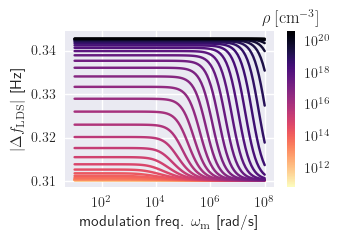

In [309]:
figs['01'] = plot_LDS(expt['01'], n=5, scaled=False)
figs['01']

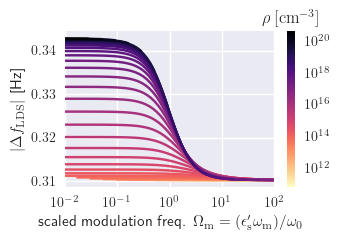

In [310]:
figs['02'] = plot_LDS(expt['01'], n=5, scaled=True)
figs['02'].axes[0].set_xlim([1e-2,1e2]);
figs['02']

## Plot the zero-frequency limit of the LDS spectra

Adapt this code from `dissipation7.py`, tweaking it to plot the low- and high-conductivity limits.

In [303]:
dfdclims(obj)/2

array([-0.3428703 , -0.31021895])

In [304]:
def plot_BLDS_zero(self, obj, abs=False):

    [df_metal, df_diel] = dfdclims(obj) / 2
    
    y = np.array([x[0] for x in self.df['f_LDS [Hz]'].values])
    if abs:
        y = np.abs(y)

    x1 = self.df['rho scaled 3'].values
    x2 = self.df['rho [1/cm^3]'].values

    # Define functions to convert from  $\hat{\rho}$ to $\rho$ and back again

    c = (x2/x1)[0]
    fwd = lambda x1: x1*c
    rev = lambda x2: x2/c 

    with plt.style.context('seaborn-v0_8'):

        fig, ax1 = plt.subplots(1, 1, figsize=(4.00, 2.75))

        ax1.semilogx(x1, y)
        
        ax1.hlines(df_diel, min(x1), 100.0, linestyles='-.', colors='tab:gray', label='dielectric') 
        ax1.hlines(df_metal, 0.01, max(x1), linestyles='--', colors='tab:gray', label='metal') 

        if abs:
            ax1.set_ylabel(r'$|\Delta f_{\mathrm{LDS}}(\omega_{\mathrm{m}}=0)|$ [Hz]')
        else:
            ax1.set_ylabel(r'$\Delta f_{\mathrm{LDS}}(\omega_{\mathrm{m}}=0)$ [Hz]')

        if plt.rcParams['text.usetex']:
            ax1.set_xlabel(
                r'scaled charge density $\hat{\rho}_3 = '
                r'z^2_{\mathrm{c}} \Big/ 7.742 \, \epsilon^{\prime}_{\mathrm{s}} \lambda^2_{\mathrm{D}}$')
        else:
             ax1.set_xlabel(
                r'scaled charge density $\hat{\rho}_3 = '
                r'z^2_{\mathrm{c}} \: / \: 7.742 \, \epsilon^{\prime}_{\mathrm{s}} \lambda^2_{\mathrm{D}}$')

        ax2 = ax1.secondary_xaxis("top", functions=(fwd,rev))
        ax2.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
        
        plt.legend(frameon=True, framealpha=1, loc=6, handlelength=3.5)
        plt.tight_layout()

    return fig

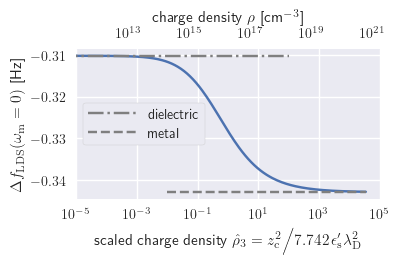

In [311]:
figs['03'] = plot_BLDS_zero(expt['01'], obj)
figs['03'].axes[0].set_xlim([1e-5,1e5]);
figs['03']

## Plot the friction

Adapt this code from `dissipation7.py`, tweaking it because now each row in the dataframe `df` contains an *array* of friction values.

In [397]:
def plot_friction(self):

    y = np.array([row[0] for row in self.df['gamma [pN s/m]']])
    x1 = self.df['omega_c scaled'].values
    x2 = self.df['rho [1/cm^3]'].values

    # Define functions to convert from  $\hat{\rho}$ to $\rho$ and back again

    c = (x2/x1)[0]
    fwd = lambda x1: x1*c
    rev = lambda x2: x2/c 

    with plt.style.context('seaborn-v0_8'):

        fig, ax1 = plt.subplots(1, 1, figsize=(3.00, 2.50))

        ax1.semilogx(x1, y)
        ax1.set_ylabel((r'friction $\gamma_{\perp}$ [pN s/m]'))
        ax1.set_xlabel(r'scaled frequency $\Omega_0 = '
                       r'\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')

        ax2 = ax1.secondary_xaxis("top", functions=(fwd,rev))
        ax2.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
        plt.tight_layout()

    return fig

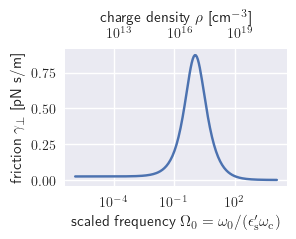

In [398]:
figs['04'] = plot_friction(expt['01'])
figs['04']

This looks reasonable.

Vary $\epsilon_{\mathrm{s}}^{\prime\prime}$. \
The following similation is expected to take 12 to 15 minutes to run.

In [399]:
%%time

epsilon_s_start = sample3.epsilon_s
epsilon_list = [20-0.02j, 20-0.2j, 20-0.5j, 20-1j]

objs = {}
for key, epsilon_s in zip(['02a', '02b', '02c', '02d'], epsilon_list):
    
    sample3.epsilon_s = ureg.Quantity(epsilon_s, '')
    sample3_jit = SampleModel3Jit(**sample3.args())

    expt[key] = ExptSweepConductivity1('perovskite-like sample')
    objs[key] = expt[key].calculate(
        sample3_jit, 
        h, 
        ureg.Quantity(250.,'Hz'),
        omega_m__array,
        rho__array,
        sigma__array)

sample3.epsilon_s = epsilon_s_start             # reset it
sample3_jit = SampleModel3Jit(**sample3.args()) # reset it

CPU times: user 1h 13min 2s, sys: 7min 29s, total: 1h 20min 32s
Wall time: 10min 14s


A helper function used in the following plot.

In [400]:
def latex_float(f):
    """Example function call.

        latex_float(3e-7)
        => '$3.0 \\times 10^{-7}$'
        
    """
    float_str = "{0:.1e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str 

Use the first data set, `'02a'`, to create the figure.  \
Then add the plots for the subsequent three datasets to the figure. \
Finally, add a legend covering all four datasets.

In [401]:
figs['05'] = plot_friction(expt['02a'])

with plt.style.context('seaborn-v0_8'):

    for key in ['02b', '02c', '02d']:

        figs['05'].axes[0].semilogx(
            expt[key].df['omega_c scaled'].values,
            np.array([row[0] for row in expt[key].df['gamma [pN s/m]']]))

    figs['05'].axes[0].legend(
        [latex_float(ep.imag) for ep in epsilon_list], 
        title=r'$\epsilon_{\mathrm{s}}^{\prime\prime}$',
        fontsize=8,
        title_fontsize=10,
        frameon=True)

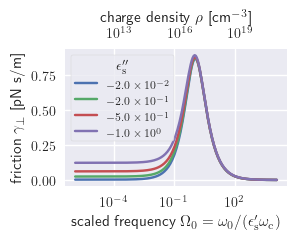

In [402]:
figs['05']

Vary $\mu$. \
The following similation is expected to take 12 to 15 minutes to run.

In [403]:
%%time

rho__array__start = rho__array # save it
mu_list = [ureg.Quantity(val, 'cm^2/(V s)') for val in [1e-6, 1e-4, 1e-3, 1e-2]]

for key, mu in zip(['03a', '03b', '03c', '03d'], mu_list):
    
    rho__array = (sigma__array / (qe * mu)).to('1/m^3')
    
    expt[key] = ExptSweepConductivity1('perovskite-like sample')
    objs[key] = expt[key].calculate(
        sample3_jit, 
        h, 
        ureg.Quantity(250.,'Hz'),
        omega_m__array,
        rho__array,
        sigma__array)    
    
rho__array = rho__array__start # reset it

CPU times: user 1h 14min 20s, sys: 7min 43s, total: 1h 22min 3s
Wall time: 10min 25s


To plot, we cannot use *both* a common scaled frequecy axis *and* a second charge-density axis.

In [433]:
def plot_friction_list(expt, keys, scaled=False):

    with plt.style.context('seaborn-v0_8'):

        fig, ax = plt.subplots(1, 1, figsize=(3.75, 2.50))

        for key in keys:

            if scaled:
                x = expt[key].df['omega_c scaled'].values
            else:    
                x = expt[key].df['rho [1/cm^3]'].values    
            
            y = np.array([row[0] for row in expt[key].df['gamma [pN s/m]']])        

            plt.loglog(x, y)
        
        ax.set_ylabel((r'friction $\gamma_{\perp}$ [pN s/m]'))
        
        if scaled:
            ax.set_xlabel(r'scaled frequency $\Omega_0 = '
                          r'\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
        else:
            ax.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
        
        plt.tight_layout()

    return fig

There is a small negative imaginary part to the dielectric constant. 

In [434]:
sample3_jit.epsilon_s

(20-0.02j)

Plot the friction versus charge density for different values of the mobility.

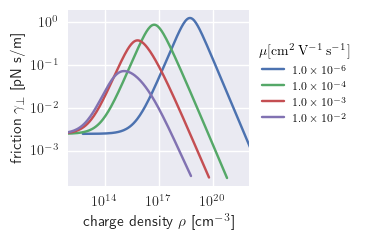

In [437]:
figs['06'] = plot_friction_list(expt, ['03a', '03b', '03c', '03d'])
figs['06'].gca().set_xlim([1e12,1e22]);
figs['06'].axes[0].legend(
    [latex_float(mu.to('cm^2/(V s)').magnitude) for mu in mu_list], 
    title=r'$\mu [\mathrm{cm}^{2} \: \mathrm{V}^{-1} \: \mathrm{s}^{-1}]$',
    fontsize=8,
    title_fontsize=10,
    frameon=False,
    bbox_to_anchor=(1, 0.3))
figs['06'].tight_layout()

figs['06']

Now plot the friction versus scaled frequency.

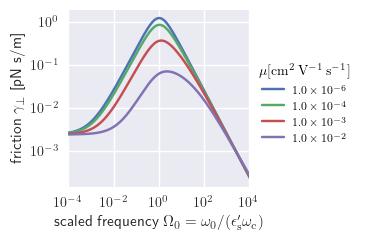

In [438]:
figs['07'] = plot_friction_list(expt, ['03a', '03b', '03c', '03d'], scaled=True)
figs['07'].gca().set_xlim([1e-4,1e+4]);
figs['07'].axes[0].legend(
    [latex_float(mu.to('cm^2/(V s)').magnitude) for mu in mu_list], 
    title=r'$\mu [\mathrm{cm}^{2} \: \mathrm{V}^{-1} \: \mathrm{s}^{-1}]$',
    fontsize=8,
    title_fontsize=10,
    frameon=False,
    bbox_to_anchor=(1, 0.75))
figs['07'].tight_layout()

figs['07']

::: {.content-hidden when-format="html"}

# Save the figures

In [439]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  During development you can run the following command to render and display an `html` file on the fly.

    quarto preview dissipation-theory--Study-74.ipynb

When you are done developing this notebook, run  `quarto` from the command line as follows to create a nicely-formated `.html` version of the notebook.

    quarto render dissipation-theory--Study-74.ipynb && open dissipation-theory--Study-74.html
    
:::